In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
import seaborn as sns
import itertools
from tqdm import tqdm
import joblib

In [2]:
d0 = np.array([1.])

In [3]:
use_πD = False

In [4]:
N = 200

# %Missing counterfactual annotations, constant mean split weights, no impute

In [5]:
def single_run_pcannot(pc_annots, runs=1000, annot_std_scale=1.0):
    np.random.seed(42)

    ## probability of getting a counterfactual annotation
    Pc_local = pc_annots
    
    ww = ww_constant
    
    # True value of π_e
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0), 
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))


    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc_local[xi,ai], Pc_local[xi,ai]]) for xi,ai in zip(x,a)])
        
        # counterfactual reward
        rc = np.array([rng_c.normal(R[xi,1-ai], annot_std_scale*sigma[xi,1-ai]) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # trajectory-wise weight
        w = np.ones(N)
        w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
        wc = np.zeros(N)
        wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]
        
        # print(x,a,r,c,rc,w,wc)
        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))), 
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            π_b_ = np.array([
                [(1-Pc_local[0,0])*π_b[0,0] + Pc_local[0,0]*π_b[0,0]*ww[0,0,0] + Pc_local[0,1]*π_b[0,1]*ww[0,1,0], 
                 (1-Pc_local[0,1])*π_b[0,1] + Pc_local[0,0]*π_b[0,0]*ww[0,0,1] + Pc_local[0,1]*π_b[0,1]*ww[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)

        # print(π_b_)
        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    df_bias_var = []
    for name, values in [
        ('$\hat{v}(\pi_e)$', Js),
        ('$\hat{v}(\pi_b)$', Gs),
        ('OIS', OISs),
        ('WIS', WISs),
        ('C-OIS', FC_OISs_w),
        ('C-WIS', FC_WISs_w),
    ]:
        df_bias_var.append([name, 
                            np.mean(values), 
                            np.mean(values - d0@np.sum(π_e*R, axis=1)), 
                            np.sqrt(np.var(values)), 
                            np.sqrt(np.mean(np.square(values - d0@np.sum(π_e*R, axis=1))))])
    return pd.DataFrame(df_bias_var, columns=['Approach', 'Mean', 'Bias', 'Std', 'RMSE'])

In [6]:
ww_constant = np.array([[
    [0.5, 0.5],
    [0.5, 0.5],
]])

In [7]:
pc_annot_list = list(np.arange(0,1+1e-10,0.1).round(2))
pc_annot_list

[np.float64(0.0),
 np.float64(0.1),
 np.float64(0.2),
 np.float64(0.3),
 np.float64(0.4),
 np.float64(0.5),
 np.float64(0.6),
 np.float64(0.7),
 np.float64(0.8),
 np.float64(0.9),
 np.float64(1.0)]

In [8]:
R, sigma = np.array([[1., 2.],]), np.array([[1., 1.],])

In [9]:
π_b = np.array([[0.8, 0.2]])
π_e = np.array([[0.1, 0.9]])
print(π_b, π_e)

[[0.8 0.2]] [[0.1 0.9]]


In [10]:
df_out_sweepPcannot_1 = []
for pc0, pc1 in tqdm(list(itertools.product(pc_annot_list, pc_annot_list))):
    df_out = single_run_pcannot(np.array([[pc0, pc1]]), runs=50)
    df_out_sweepPcannot_1.append(df_out)

100%|██████████| 121/121 [00:42<00:00,  2.87it/s]


In [11]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepPcannot_1]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'pc0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'pc1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T*np.sqrt(N)), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            vmin=-0.05, vmax=1.5,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
# ax.collections[0].colorbar.set_ticks([0, 0.25])
# ax.collections[0].colorbar.set_ticklabels(['$0$', r'$\frac{1}{4}$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('Fraction annotated\n(action 0)', labelpad=-9, fontsize=9)
plt.ylabel('Fraction annotated\n(action 1)', labelpad=-9, fontsize=9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b82_e19_Pcannot.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepPcannot_1]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, 
            # vmin=0, vmax=2, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepPcannot_1]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, 
            vmin=0, vmax=0.35, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 300x300 with 2 Axes>

In [12]:
df_plot

pc1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
pc0,,,,,,,,,,,
0.0,0.300471,0.310174,0.311540,0.304181,0.301523,0.289240,0.288613,0.289668,0.295602,0.303822,0.302355
0.1,0.246959,0.249199,0.245620,0.240136,0.239184,0.226587,0.221737,0.222201,0.226428,0.234696,0.231334
0.2,0.198126,0.202785,0.199199,0.191044,0.190688,0.182352,0.182886,0.178092,0.184377,0.185440,0.177459
0.3,0.159683,0.161364,0.159265,0.152916,0.153304,0.148964,0.149187,0.147009,0.154316,0.155064,0.151361
0.4,0.148031,0.146528,0.148610,0.143868,0.143292,0.140094,0.140369,0.136329,0.144871,0.141147,0.137414
0.5,0.138073,0.135750,0.136917,0.132786,0.132981,0.130026,0.129695,0.126084,0.131306,0.125129,0.122910
0.6,0.122529,0.119229,0.119441,0.116035,0.117058,0.113428,0.111495,0.109796,0.116878,0.112209,0.108577
0.7,0.098625,0.094568,0.094823,0.090646,0.089578,0.085806,0.083031,0.082587,0.091059,0.084356,0.082023
0.8,0.093984,0.091676,0.091066,0.086733,0.085474,0.083441,0.080933,0.080488,0.085733,0.080427,0.077919


In [13]:
df_plot.mean()

pc1
0.0    0.151552
0.1    0.151252
0.2    0.150581
0.3    0.145641
0.4    0.144929
0.5    0.139937
0.6    0.138422
0.7    0.137245
0.8    0.143378
0.9    0.141831
1.0    0.139116
dtype: float64

In [14]:
single_run_pcannot(np.array([[0,0]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.900105,0.000105,0.047888,0.047888
1,$\hat{v}(\pi_b)$,1.181105,-0.718895,0.064291,0.721764
2,OIS,1.934165,0.034165,0.378242,0.379782
3,WIS,1.985829,0.085829,0.133283,0.158527
4,C-OIS,1.934165,0.034165,0.378242,0.379782
5,C-WIS,1.985829,0.085829,0.133283,0.158527


In [15]:
single_run_pcannot(np.array([[1,1]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.900105,0.000105,0.047888,0.047888
1,$\hat{v}(\pi_b)$,1.181105,-0.718895,0.064291,0.721764
2,OIS,1.934165,0.034165,0.378242,0.379782
3,WIS,1.985829,0.085829,0.133283,0.158527
4,C-OIS,1.921486,0.021486,0.047601,0.052225
5,C-WIS,1.921486,0.021486,0.047601,0.052225


In [16]:
single_run_pcannot(np.array([[0.5, 0.5]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.900105,0.000105,0.047888,0.047888
1,$\hat{v}(\pi_b)$,1.181105,-0.718895,0.064291,0.721764
2,OIS,1.934165,0.034165,0.378242,0.379782
3,WIS,1.985829,0.085829,0.133283,0.158527
4,C-OIS,1.904919,0.004919,0.148637,0.148719
5,C-WIS,1.936890,0.036890,0.066036,0.075641


# %Missing counterfactual annotations, constant mean split weights, impute annotations

In [18]:
def single_run_pcannot_impute(pc_annots, runs=1000, annot_std_scale=1.0):
    np.random.seed(42)

    ## probability of getting a counterfactual annotation
    Pc_local = pc_annots
    
    ww = ww_constant
    
    # True value of π_e
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0), 
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))


    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc_local[xi,ai], Pc_local[xi,ai]]) for xi,ai in zip(x,a)])
        # print(c)

        # counterfactual reward
        rc = np.array([rng_c.normal(R[xi,1-ai], annot_std_scale*sigma[xi,1-ai]) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # impute missing counterfactuals
        rc_impute = np.full_like(rc, np.nan)
        c_impute = np.full_like(c, 0)
        for i, (ci,xi,ai) in enumerate(zip(c,x,a)):
            if ci == 1:
                pass
            else:
                rc_src = rc[(c==1) & (x==xi) & (a==ai)]
                if len(rc_src) > 0:
                    rc_impute[i] = np.mean(rc_src)
                    c_impute[i] = 1
        
        rc[c==0] = rc_impute[c==0]
        c[c==0] = c_impute[c==0]
        
        # trajectory-wise weight
        w = np.ones(N)
        w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
        wc = np.zeros(N)
        wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]
        
        # print('a', a, 'r', r, 'c', c, 'rc', rc, 'w', w, 'wc', wc)
        # print(np.sum(w), np.sum(wc))
        
        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))), 
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            Pc_round = (Pc_local > 0).astype(int)
            π_b_ = np.array([
                [(1-Pc_round[0,0])*π_b[0,0] + Pc_round[0,0]*π_b[0,0]*ww[0,0,0] + Pc_round[0,1]*π_b[0,1]*ww[0,1,0], 
                 (1-Pc_round[0,1])*π_b[0,1] + Pc_round[0,0]*π_b[0,0]*ww[0,0,1] + Pc_round[0,1]*π_b[0,1]*ww[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)
        # print(Pc_local)
        # print(Pc_round)
        # print(π_b_)
        
        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    df_bias_var = []
    for name, values in [
        ('$\hat{v}(\pi_e)$', Js),
        ('$\hat{v}(\pi_b)$', Gs),
        ('OIS', OISs),
        ('WIS', WISs),
        ('C-OIS', FC_OISs_w),
        ('C-WIS', FC_WISs_w),
    ]:
        df_bias_var.append([name, 
                            np.mean(values), 
                            np.mean(values - d0@np.sum(π_e*R, axis=1)), 
                            np.sqrt(np.var(values)), 
                            np.sqrt(np.mean(np.square(values - d0@np.sum(π_e*R, axis=1))))])
    return pd.DataFrame(df_bias_var, columns=['Approach', 'Mean', 'Bias', 'Std', 'RMSE'])

In [92]:
single_run_pcannot_impute(np.array([[0., 0.1]]), runs=5)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.906469,0.006469,0.117766,0.117944
1,$\hat{v}(\pi_b)$,1.208469,-0.691531,0.132154,0.704045
2,OIS,1.831194,-0.068806,0.215124,0.225860
3,WIS,1.948024,0.048024,0.206336,0.211851
4,C-OIS,2.522573,0.622573,0.926232,1.116021
5,C-WIS,1.976511,0.076511,0.233438,0.245657


In [19]:
single_run_pcannot(np.array([[0., 0.1]]), runs=5)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.903350,0.003350,0.060292,0.060385
1,$\hat{v}(\pi_b)$,1.194350,-0.705650,0.073600,0.709478
2,OIS,1.964524,0.064524,0.365393,0.371046
3,WIS,2.026814,0.126814,0.151023,0.197205
4,C-OIS,1.924688,0.024688,0.353325,0.354186
5,C-WIS,2.007996,0.107996,0.156705,0.190314


In [20]:
ww_constant = np.array([[
    [0.5, 0.5],
    [0.5, 0.5],
]])

In [29]:
pc_annot_list = list(np.arange(0,1+1e-10,0.1).round(2))
pc_annot_list

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [30]:
R, sigma = np.array([[1., 2.],]), np.array([[1., 1.],])

In [31]:
π_b = np.array([[0.8, 0.2]])
π_e = np.array([[0.1, 0.9]])
print(π_b, π_e)

[[0.8 0.2]] [[0.1 0.9]]


In [104]:
df_out_sweepPcannot_2 = []
for pc0, pc1 in tqdm(list(itertools.product(pc_annot_list, pc_annot_list))):
    df_out = single_run_pcannot_impute(np.array([[pc0, pc1]]), runs=50)
    df_out_sweepPcannot_2.append(df_out)

100%|██████████| 121/121 [10:58<00:00,  5.44s/it]


$R_0 \sim N(1.0,1.0^2)$, $R_1 \sim N(2.0, 1.0^2)$ 
 $\pi_b=[0.8,0.2]$, $\pi_e=[0.1,0.9]$


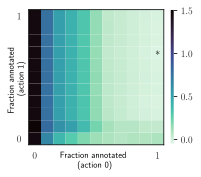

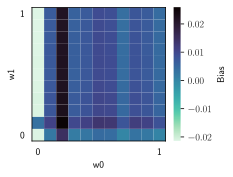

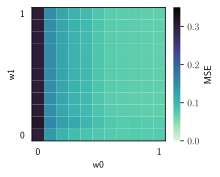

In [114]:
variances_grid = [df__.iloc[4,3] for df__ in df_out_sweepPcannot_2]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(variances_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

# sns.heatmap(df_plot.T, cmap='crest', square=True, ax=ax,
#             cbar_kws={'label': 'Var', "shrink": .82}, vmin=0, vmax=4)
sns.heatmap(np.log(df_plot.T*np.sqrt(N)), cmap='mako_r', square=True, ax=ax,
            cbar_kws=dict(shrink=.82, aspect=40, pad=0.04), 
            vmin=-0.05, vmax=1.5,
           )
# ax.collections[0].colorbar.set_label('$\log(\mathrm{Var})$', labelpad=-9, fontsize=8)
# ax.collections[0].colorbar.set_ticks([0, 0.25])
# ax.collections[0].colorbar.set_ticklabels(['$0$', r'$\frac{1}{4}$'])
plt.xticks([0.5,10.5], ['$0$','$1$'], rotation=0)
plt.yticks([0.5,10.5], ['$0$','$1$'])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.xlabel('Fraction annotated\n(action 0)', labelpad=-9, fontsize=9)
plt.ylabel('Fraction annotated\n(action 1)', labelpad=-9, fontsize=9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')
    if np.isclose(df_plot.loc[w0,w1], np.nanmin(df_plot.values)):
        plt.annotate('$*$', (i+0.5,j+0.5), c='k', ha='center', va='center')
        # plt.plot(i+0.5,j+0.5, marker='.', c='yellow', ms=3)

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

print('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
    R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
))
plt.savefig('fig/bandit_logvar_b82_e19_Pcannot_impute.pdf', bbox_inches='tight')
plt.show()
# display(df_plot)


biases_grid = [df__.iloc[4,2] for df__ in df_out_sweepPcannot_2]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(biases_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'Bias', "shrink": .82}, 
            # vmin=0, vmax=2, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()


mses_grid = [df__.iloc[4,4] for df__ in df_out_sweepPcannot_2]

fig, ax = plt.subplots(figsize=(3,3))
df_plot = pd.DataFrame(np.array(mses_grid).reshape((11,11)), index=pc_annot_list, columns=pc_annot_list)
df_plot.index.name = 'w0'
df_plot.index = np.round(df_plot.index, 5)
df_plot.columns.name = 'w1'
df_plot.columns = np.round(df_plot.columns, 5)

sns.heatmap(df_plot.T, cmap='mako_r', square=True, cbar_kws={'label': 'MSE', "shrink": .82}, 
            vmin=0, vmax=0.35, 
            ax=ax)
plt.xticks([0.5,10.5], [0,1], rotation=0)
plt.yticks([0.5,10.5], [0,1])
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
# plt.xlabel('$W(\\tilde{a}=0|s,a=0)$', labelpad=-9)
# plt.ylabel('$W(\\tilde{a}=1|s,a=1)$', labelpad=-9)

for (i,w0), (j,w1) in itertools.product(enumerate(pc_annot_list), enumerate(pc_annot_list)):
    if np.isnan(df_plot.loc[w0,w1]):
        plt.plot(i+0.5,j+0.5, marker='x', c='r')

# plt.title('$R_0 \sim N({},{}^2)$, $R_1 \sim N({}, {}^2)$ \n $\pi_b=[{},{}]$, $\pi_e=[{},{}]$'.format(
#     R[0,0], sigma[0,0], R[0,1], sigma[0,1], π_b[0,0], π_b[0,1], π_e[0,0], π_e[0,1], 
# ))
plt.gca().invert_yaxis()
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.show()

In [107]:
df_plot

w1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
w0,,,,,,,,,,,
0.0,0.301216,0.314693,0.304306,0.303777,0.303371,0.303286,0.303046,0.303220,0.303056,0.303098,0.303111
0.1,0.136664,0.158921,0.153528,0.153111,0.153153,0.153700,0.153508,0.153547,0.153855,0.153855,0.153808
0.2,0.105721,0.131082,0.121686,0.121514,0.121478,0.121978,0.121712,0.121616,0.121897,0.121875,0.121903
0.3,0.094148,0.119736,0.109256,0.109226,0.108936,0.109090,0.108925,0.108730,0.108983,0.109084,0.109028
0.4,0.086074,0.103618,0.098215,0.097816,0.097224,0.097267,0.097120,0.096792,0.097016,0.097134,0.097033
0.5,0.080511,0.089001,0.083648,0.083354,0.083049,0.083223,0.082860,0.082558,0.082973,0.083060,0.083053
0.6,0.077688,0.080173,0.075391,0.074965,0.074944,0.075016,0.074535,0.074234,0.074627,0.074700,0.074654
0.7,0.076064,0.076365,0.073144,0.072726,0.072838,0.072953,0.072494,0.072093,0.072497,0.072602,0.072725
0.8,0.077088,0.077133,0.071539,0.071050,0.071233,0.071391,0.071049,0.070711,0.071131,0.071268,0.071324


In [108]:
df_plot.mean()

w1
0.0    0.108108
0.1    0.118117
0.2    0.111837
0.3    0.111453
0.4    0.111343
0.5    0.111536
0.6    0.111237
0.7    0.111025
0.8    0.111326
0.9    0.111397
1.0    0.111402
dtype: float64

In [46]:
single_run_pcannot_impute(np.array([[0,0]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.780833,-0.119167,0.223268,0.253080
5,C-WIS,1.860249,-0.039751,0.214985,0.218629


In [49]:
single_run_pcannot_impute(np.array([[1,1]]), runs=10)

,Approach,Mean,Bias,Std,RMSE
0,$\hat{v}(\pi_e)$,1.860696,-0.039304,0.113068,0.119705
1,$\hat{v}(\pi_b)$,1.162696,-0.737304,0.113893,0.746049
2,OIS,1.780833,-0.119167,0.223268,0.253080
3,WIS,1.860249,-0.039751,0.214985,0.218629
4,C-OIS,1.888505,-0.011495,0.069931,0.070870
5,C-WIS,1.888505,-0.011495,0.069931,0.070870


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



def single_run_pcannot_with_lists(pc_annots, noise_std=0.0, runs=1000, annot_std_scale=1.0):
    np.random.seed(42)

    ## probability of getting a counterfactual annotation
    Pc_local = pc_annots

    ww = ww_constant

    # True value of π_e (list of estimates)
    Js = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_e[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        J = np.sum(r) / N
        Js.append(J)

    # Standard IS (lists, no cf, so noise irrelevant)
    Gs = []
    OISs = []
    WISs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        G = np.sum(r) / N
        Gs.append(G)

        if use_πD:
            π_b_ = np.array([
                [(np.sum((x==0)&(a==0)))/np.sum(x==0),
                 (np.sum((x==0)&(a==1)))/np.sum(x==0)],
            ])
        else:
            π_b_ = π_b

        rho = π_e[x,a] / π_b_[x,a]
        OISs.append(np.sum(rho * r) / N)
        WISs.append(np.sum(rho * r) / np.sum(rho))

    # Collect data using π_b - combining counterfactuals with factuals
    FC_OISs_w = []
    FC_WISs_w = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])
        rho = π_e[x,a] / π_b[x,a]

        # counterfactual flag
        c = np.array([rng_c.choice(2, p=[1-Pc_local[xi,ai], Pc_local[xi,ai]]) for xi,ai in zip(x,a)])

        # counterfactual reward: add extra noise_std for bias
        rc = np.array([rng_c.normal(R[xi,1-ai], np.sqrt((annot_std_scale*sigma[xi,1-ai])**2 + noise_std**2)) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        # trajectory-wise weight
        w = np.ones(N)
        w[c==1] = ww[x[c==1], a[c==1], a[c==1]]
        wc = np.zeros(N)
        wc[c==1] = ww[x[c==1], a[c==1], 1-a[c==1]]

        if use_πD:
            # augmented behavior policy
            π_b_ = np.array([
                [(np.sum(w*((x==0)&(a==0)))+np.sum(wc*((x==0)&(a==1)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1)))),
                 (np.sum(w*((x==0)&(a==1)))+np.sum(wc*((x==0)&(a==0)&(c==1))))/(np.sum(w*(x==0))+np.sum(wc*((x==0)&(c==1))))],
            ])
        else:
            # augmented behavior policy
            π_b_ = np.array([
                [(1-Pc_local[0,0])*π_b[0,0] + Pc_local[0,0]*π_b[0,0]*ww[0,0,0] + Pc_local[0,1]*π_b[0,1]*ww[0,1,0],
                 (1-Pc_local[0,1])*π_b[0,1] + Pc_local[0,0]*π_b[0,0]*ww[0,0,1] + Pc_local[0,1]*π_b[0,1]*ww[0,1,1]],
            ])
            π_b_ = π_b_ / π_b_.sum(axis=1, keepdims=True)

        FC_OISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (N)
        )
        FC_WISs_w.append(
            (np.sum(w* π_e[x,a] / π_b_[x,a] * r) + np.nansum(wc* π_e[x,1-a] / π_b_[x,1-a] * rc)) / (np.sum(w* π_e[x,a] / π_b_[x,a]) + np.sum((wc* π_e[x,1-a] / π_b_[x,1-a])[c==1])),
        )

    # Return lists (true_value = d0 @ np.sum(π_e * R, axis=1) = 1.9)
    true_value = d0 @ np.sum(π_e * R, axis=1)
    return {
        'true_value': true_value,
        'OISs': OISs,  # IS ordinary
        'WISs': WISs,  # IS weighted
        'C_OISs': FC_OISs_w,  # C-IS ordinary
        'C_WISs': FC_WISs_w,  # C-IS weighted
    }

# Run three cases ( WIS / C-WIS noise=0 for perfect, noise=0.2 for biased)
# All use pc=[[1.0,1.0]] for full annotations; bias via noise on rc
results = {}
pc_full = np.array([[1.0, 1.0]])

# IS: standard (no cf, so pc=0, but since no cf used, equivalent; noise irrelevant)
pc_is = np.array([[0.0, 0.0]])
results['IS'] = single_run_pcannot_with_lists(pc_is, noise_std=0.0, runs=1000)

# C-IS perfect: full pc, no extra noise
results['C-IS (perfect)'] = single_run_pcannot_with_lists(pc_full, noise_std=0.0, runs=1000)

# C-IS biased: full pc, but extra 0.2 noise std on rc
results['C-IS (biased)'] = single_run_pcannot_with_lists(pc_full, noise_std=0.2, runs=1000)

# Prepare boxplot data (use RMSE for each run)
data_for_plot = []
true_value = results['IS']['true_value']  # Same for all
for method, res in results.items():
    if method == 'IS':
        rmses = np.sqrt( (np.array(res['WISs']) - true_value)**2 )  # Use WIS for IS
    else:
        rmses = np.sqrt( (np.array(res['C_WISs']) - true_value)**2 )  # Use C-WIS for C-IS
    data_for_plot.extend([{'method': method, 'rmse': rmse} for rmse in rmses])

plot_df = pd.DataFrame(data_for_plot)

C:\Users\Biao\AppData\Local\Temp\ipykernel_6344\1665717622.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: Fre

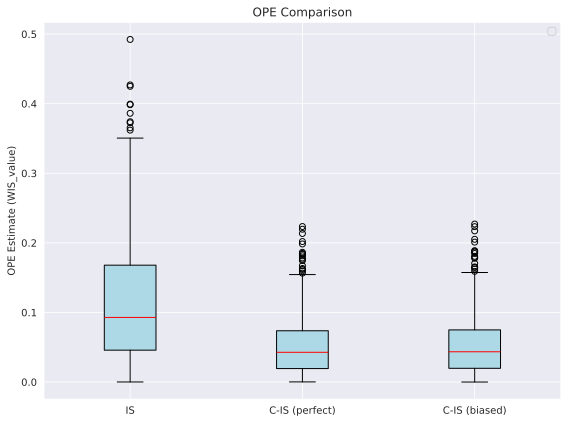

                    mean       std       min       max
method                                                
C-IS (biased)   0.051660  0.040359  0.000026  0.227032
C-IS (perfect)  0.050850  0.039717  0.000131  0.223473
IS              0.113406  0.085598  0.000055  0.492340


In [22]:
import matplotlib.pyplot as plt
# boxplot
methods = plot_df['method'].unique()
data_for_box = {}
for method in methods:
    data_for_box[method] = plot_df[plot_df['method'] == method]['rmse'].values

fig, ax = plt.subplots(figsize=(8, 6))
bp = ax.boxplot([data_for_box[m] for m in methods],
                tick_labels=methods,  # 修复：用 tick_labels 替换 labels
                patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))
ax.set_ylabel('OPE Estimate (WIS_value)')
ax.set_title('OPE Comparison')
ax.legend()
plt.tight_layout()
plt.savefig('ope_boxplot_flip200.png', dpi=300)
plt.show()

# Summary stats
print(plot_df.groupby('method')['rmse'].agg(['mean', 'std', 'min', 'max']))

In [33]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def generate_train_data(N_train=5000, use_cf=False, pc_annots=None, noise_std=0.0, annot_std_scale=1.0, mean_bias=0.0, seed=42):
    rng = np.random.default_rng(seed)
    x_train = rng.choice(1, size=N_train, p=d0)
    a_train = np.array([rng.choice(2, p=π_b[xi]) for xi in x_train])
    r_train = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x_train,a_train)])

    if use_cf and pc_annots is not None:
        rng_c = np.random.default_rng(seed + 100000)
        c = np.array([rng_c.choice(2, p=[1-pc_annots[xi,ai], pc_annots[xi,ai]]) for xi,ai in zip(x_train,a_train)])

        # Add mean_bias to rc mean for 'biased' (true bias, not just var)
        rc_train = np.array([rng_c.normal(R[xi,1-ai] + mean_bias, np.sqrt((annot_std_scale*sigma[xi,1-ai])**2 + noise_std**2)) for xi,ai in zip(x_train,a_train)])
        rc_train[c==0] = np.nan

        factual = pd.DataFrame({'s': x_train, 'a': a_train, 'r': r_train})
        cf = pd.DataFrame({'s': x_train[c==1], 'a': 1 - a_train[c==1], 'r': rc_train[c==1]})
        train_df = pd.concat([factual, cf], ignore_index=True)
    else:
        train_df = pd.DataFrame({'s': x_train, 'a': a_train, 'r': r_train})

    return train_df

def train_reward_model(train_df):
    X = train_df[['s', 'a']].values
    y = train_df['r'].values
    reg = LinearRegression().fit(X, y)
    return reg

def predict_R_V(model, s, π_e):
    a0 = np.array([[s[0], 0]])  # s is array [0]
    a1 = np.array([[s[0], 1]])
    R0 = model.predict(a0)[0]
    R1 = model.predict(a1)[0]
    V = π_e[0,0] * R0 + π_e[0,1] * R1
    return R0, R1, V

# Update single_run_DR: pass train_seed = different per run
def single_run_DR(runs=1000):
    true_value = d0 @ np.sum(π_e * R, axis=1)
    DRs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])

        # Independent train with varying seed
        train_df = generate_train_data(N_train=1000, use_cf=False, seed=200000 + seed)
        model = train_reward_model(train_df)

        est = 0
        for i in range(N):
            s_i = x[i]
            a_i = a[i]
            r_i = r[i]
            ρ_i = π_e[s_i, a_i] / π_b[s_i, a_i]
            _, _, V_i = predict_R_V(model, [s_i], π_e)
            R_i = model.predict(np.array([[s_i, a_i]]))[0]
            est += V_i + ρ_i * (r_i - R_i)
        DRs.append(est / N)

    return {'DRs': DRs, 'true_value': true_value}

# Update single_run_CANDOR: similar, vary train seed
def single_run_CANDOR(pc_annots, noise_std=0.0, mean_bias=0.0, runs=1000, annot_std_scale=1.0):
    true_value = d0 @ np.sum(π_e * R, axis=1)
    CANDORs = []
    for seed in range(runs):
        rng = np.random.default_rng(seed=10+seed)
        rng_c = np.random.default_rng(seed=100000+seed)
        x = rng.choice(1, size=N, p=d0)
        a = np.array([rng.choice(2, p=π_b[xi]) for xi in x])
        r = np.array([rng.normal(R[xi,ai], sigma[xi,ai]) for xi,ai in zip(x,a)])

        c = np.array([rng_c.choice(2, p=[1-pc_annots[xi,ai], pc_annots[xi,ai]]) for xi,ai in zip(x,a)])
        rc = np.array([rng_c.normal(R[xi,1-ai], np.sqrt((annot_std_scale*sigma[xi,1-ai])**2 + noise_std**2)) for xi,ai in zip(x,a)])
        rc[c==0] = np.nan

        train_df = generate_train_data(N_train=5000, use_cf=True, pc_annots=pc_annots, noise_std=noise_std, mean_bias=mean_bias, annot_std_scale=annot_std_scale, seed=200000 + seed)
        model = train_reward_model(train_df)

        est = 0
        for i in range(N):
            s_i = x[i]
            a_i = a[i]
            r_i = r[i]
            ρ_i = π_e[s_i, a_i] / π_b[s_i, a_i]
            _, _, V_i = predict_R_V(model, [s_i], π_e)
            R_i = model.predict(np.array([[s_i, a_i]]))[0]
            est += V_i + ρ_i * (r_i - R_i)
        CANDORs.append(est / N)

    return {'CANDORs': CANDORs, 'true_value': true_value}


In [34]:
runs_large = 10000

# 1.IS
pc_is = np.array([[0.0, 0.0]])
is_results = single_run_pcannot_with_lists(pc_is, noise_std=0.0, runs=runs_large)

# 2.C-IS
pc_perfect = np.array([[1.0, 1.0]])
c_is_perfect = single_run_pcannot_with_lists(pc_perfect, noise_std=0.0, runs=runs_large)

c_is_biased = single_run_pcannot_with_lists(pc_perfect, noise_std=0.2, runs=runs_large)  # pc=1 but noise for bias

# 3. DR
dr_results = single_run_DR(runs=runs_large)

# 4-5. CANDOR
candor_perfect = single_run_CANDOR(pc_perfect, noise_std=0.0, runs=runs_large)
candor_biased = single_run_CANDOR(pc_perfect, noise_std=0.2, runs=runs_large)

C:\Users\Biao\AppData\Local\Temp\ipykernel_6344\3185166921.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([rmses_dict[m] for m in all_results.keys()], labels=list(all_results.keys()), patch_artist=True, medianprops=dict(color='red'), showfliers=False)


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: float or None
  animated: bool
  antialiased: bool
  backgroundcolor: :mpltype:`color`
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: :mpltype:`color`
  figure: `~matplotlib.figure.Figure` or `~matplotlib.figure.SubFigure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 

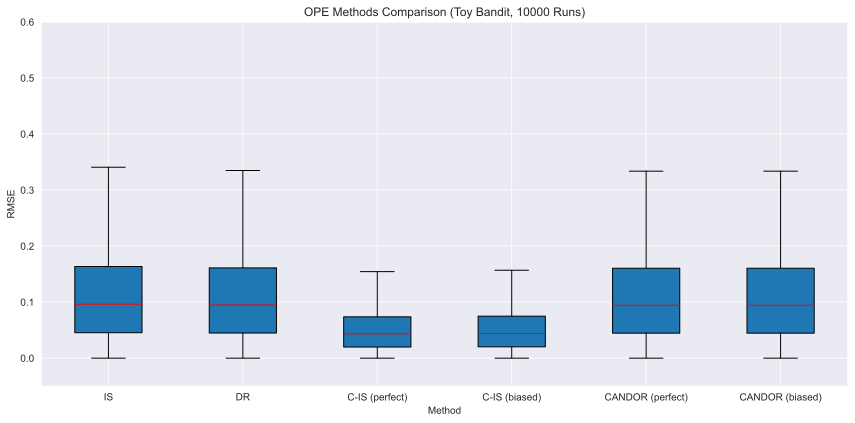

          IS      DR  C-IS (perfect)  C-IS (biased)  CANDOR (perfect)  \
mean  0.1139  0.1127          0.0510         0.0518            0.1125   
std   0.0867  0.0860          0.0385         0.0392            0.0858   

      CANDOR (biased)  
mean           0.1125  
std            0.0858  


In [57]:
# Collect all
all_results = {
    'IS': np.array(is_results['WISs']),
    'DR': np.array(dr_results['DRs']),
    'C-IS (perfect)': np.array(c_is_perfect['C_WISs']),
    'C-IS (biased)': np.array(c_is_biased['C_WISs']),
    'CANDOR (perfect)': np.array(candor_perfect['CANDORs']),
    'CANDOR (biased)': np.array(candor_biased['CANDORs'])
}

true_value = dr_results['true_value']  # Consistent

# RMSEs
rmses_dict = {method: np.sqrt((ests - true_value)**2) for method, ests in all_results.items()}

# Data for plot
data_for_plot = []
for method, rmses in rmses_dict.items():
    data_for_plot.extend([{'method': method, 'rmse': rmse} for rmse in rmses])
plot_df = pd.DataFrame(data_for_plot)

# Boxplot with plt
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot([rmses_dict[m] for m in all_results.keys()], labels=list(all_results.keys()), patch_artist=True, medianprops=dict(color='red'), showfliers=False)
ax.set_title('OPE Methods Comparison (Toy Bandit, 10000 Runs)')
ax.set_ylabel('RMSE')
ax.set_xlabel('Method')
ax.set_ylim(-0.05, 0.6)
plt.setp(ax.get_xticklabels())
plt.tight_layout()
plt.savefig('ope_boxplot_bandit.png', dpi=300)
plt.show()

# Summary table
summary = pd.DataFrame(rmses_dict).agg(['mean', 'std']).round(4)
print(summary)

C:\Users\Biao\AppData\Local\Temp\ipykernel_6344\2745227570.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([rmses_dict[m] for m in all_results.keys()], labels=list(all_results.keys()), patch_artist=True,


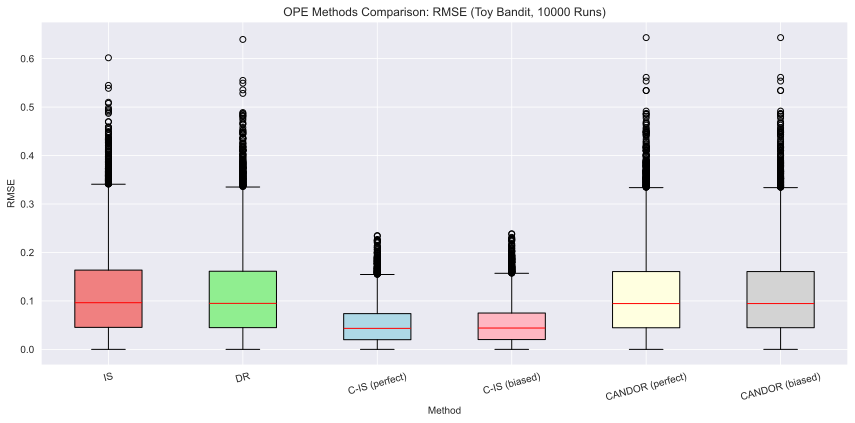

          IS      DR  C-IS (perfect)  C-IS (biased)  CANDOR (perfect)  \
mean  0.1139  0.1127          0.0510         0.0518            0.1125   
std   0.0867  0.0860          0.0385         0.0392            0.0858   

      CANDOR (biased)  
mean           0.1125  
std            0.0858  


In [52]:
# Collect all
all_results = {
    'IS': np.array(is_results['WISs']),
    'DR': np.array(dr_results['DRs']),
    'C-IS (perfect)': np.array(c_is_perfect['C_WISs']),
    'C-IS (biased)': np.array(c_is_biased['C_WISs']),
    'CANDOR (perfect)': np.array(candor_perfect['CANDORs']),
    'CANDOR (biased)': np.array(candor_biased['CANDORs'])
}

true_value = dr_results['true_value']  # Consistent

# RMSEs
rmses_dict = {method: np.sqrt((ests - true_value)**2) for method, ests in all_results.items()}

# Data for plot
data_for_plot = []
for method, rmses in rmses_dict.items():
    data_for_plot.extend([{'method': method, 'rmse': rmse} for rmse in rmses])
plot_df = pd.DataFrame(data_for_plot)

# Boxplot with plt
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot([rmses_dict[m] for m in all_results.keys()], labels=list(all_results.keys()), patch_artist=True,
                boxprops=dict(facecolor='lightblue'), medianprops=dict(color='red'))
colors = ['lightcoral', 'lightgreen', 'lightblue', 'lightpink', 'lightyellow', 'lightgray']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_title('OPE Methods Comparison: RMSE (Toy Bandit, 10000 Runs)')
ax.set_ylabel('RMSE')
ax.set_xlabel('Method')
plt.setp(ax.get_xticklabels(), rotation=15)
plt.tight_layout()
plt.show()

# Summary table
summary = pd.DataFrame(rmses_dict).agg(['mean', 'std']).round(4)
print(summary)